In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

from datetime import datetime

In [2]:
lr=1e-5
batch_size = 100
n_epochs = 10

In [3]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),   
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),   
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
train_dataset = torchvision.datasets.ImageFolder(
    root='../data/chest_xray/chest_xray/train/',
    transform=train_transforms
)

test_dataset = torchvision.datasets.ImageFolder(
    root='../data/chest_xray/chest_xray/test/',
    transform=test_transforms
)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device.upper()} is used')

Device: CUDA is used


In [7]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
)

In [8]:
model = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
classifier_in = model.classifier[0].in_features
model.classifier = nn.Sequential(
    nn.Linear(classifier_in, 1),
    nn.Sigmoid(),
)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [11]:
def validate(dataset, batch_size=128):
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
    )

    tot_predicted = 0
    tot_correct = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)

        tot_predicted += inputs.shape[0]
        outputs = model(inputs)

        predictions = torch.round(outputs)

        tot_correct += (predictions == targets).sum()

    return (tot_correct/tot_predicted)

In [12]:
def train(n_epochs=100):
    
    train_losses = np.zeros(n_epochs)
    test_losses = np.zeros(n_epochs)
    train_accuracies = np.zeros(n_epochs)
    test_accuracies = np.zeros(n_epochs)

    for it in range(n_epochs):
        
        start_time = datetime.now()

        train_loss = []
        test_loss = []

        for i, (inputs, targets) in enumerate(train_dataloader):
            inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)
            optimizer.zero_grad()

            outputs = model(inputs)
            
            loss = criterion(outputs, targets.to(torch.float32))
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        train_losses[it] = np.mean(train_loss)

        for i, (inputs, targets) in enumerate(test_dataloader):
            inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)

            outputs = model(inputs)
            loss = criterion(outputs, targets.to(torch.float32))
            test_loss.append(loss.item())

        test_losses[it] = np.mean(test_loss)

        train_accuracies[it] = validate(train_dataset, batch_size=batch_size)
        test_accuracies[it] = validate(test_dataset, batch_size=batch_size)

        duration = datetime.now()-start_time
        
        print(
            f"Iteration: {it+1:2}/{n_epochs}\tTrain Loss: {train_losses[it]:.6f}\tTest Loss: {test_losses[it]:.6f}\tTrain Accuracy: {train_accuracies[it]:.2f}\tTest Accuracy: {test_accuracies[it]:.2f}\tDuration: {duration}"
        )

    return train_losses, test_losses, train_accuracies, test_accuracies


In [13]:
train_losses, test_losses, train_accuracies, test_accuracies = train(n_epochs=n_epochs)


Iteration:  1/10	Train Loss: 0.540105	Test Loss: 0.551996	Train Accuracy: 0.76	Test Accuracy: 0.67	Duration: 0:05:54.756869
Iteration:  2/10	Train Loss: 0.425947	Test Loss: 0.473629	Train Accuracy: 0.82	Test Accuracy: 0.77	Duration: 0:04:02.742849
Iteration:  3/10	Train Loss: 0.360273	Test Loss: 0.428092	Train Accuracy: 0.88	Test Accuracy: 0.81	Duration: 0:04:02.813312
Iteration:  4/10	Train Loss: 0.308972	Test Loss: 0.394118	Train Accuracy: 0.89	Test Accuracy: 0.82	Duration: 0:04:07.711371
Iteration:  5/10	Train Loss: 0.278927	Test Loss: 0.373744	Train Accuracy: 0.92	Test Accuracy: 0.83	Duration: 0:06:04.538675
Iteration:  6/10	Train Loss: 0.251606	Test Loss: 0.356768	Train Accuracy: 0.92	Test Accuracy: 0.84	Duration: 0:05:55.999793
Iteration:  7/10	Train Loss: 0.234982	Test Loss: 0.342101	Train Accuracy: 0.93	Test Accuracy: 0.84	Duration: 0:05:41.477014
Iteration:  8/10	Train Loss: 0.219774	Test Loss: 0.331815	Train Accuracy: 0.94	Test Accuracy: 0.85	Duration: 0:05:44.460872
Iteratio

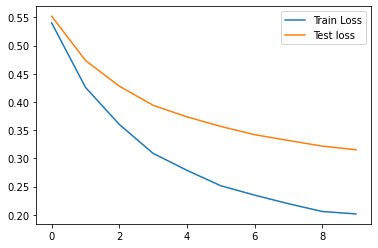

In [14]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test loss')
plt.legend()

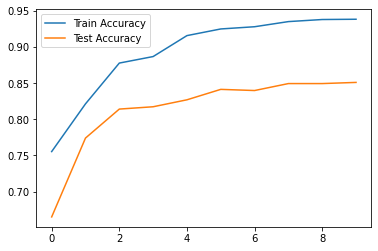

In [15]:
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.legend()